In [1]:
#!pip install -U datasets seqeval

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import random
import numpy as np
from seqeval.metrics import classification_report, f1_score, accuracy_score
import os
import requests
import zipfile

import torch.nn.functional as F
from torch.utils.data import TensorDataset

In [3]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)} # converts labels to indices

In [6]:

from gensim.models import Word2Vec

def extract_sentences_and_labels(dataset_split):
    sentences = []
    labels = []
    for item in dataset_split:
        sentences.append(item['tokens'])   # tokenized sentence
        labels.append(item['ner_tags'])    # corresponding labels
    return sentences, labels

train_sentences, train_labels = extract_sentences_and_labels(dataset['train'])
test_sentences, test_labels = extract_sentences_and_labels(dataset['test'])

train_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in train_labels]
test_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in test_labels]

# Train Word2Vec on the training sentences
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Build vocabulary and embedding matrix
all_words = set(word for sentence in train_sentences for word in sentence)
vocab = {word: idx + 2 for idx, word in enumerate(all_words)}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

embedding_matrix = np.zeros((len(vocab), 100))
for word, i in vocab.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(100,))


In [7]:
# Prepare input sequences and pad
MAX_LEN = 256
def encode_sentence(sentence):
    ids = [vocab.get(word, 1) for word in sentence]
    return ids[:MAX_LEN] + [0] * (MAX_LEN - len(ids))

def encode_labels(label_seq):
    return label_seq[:MAX_LEN] + [0] * (MAX_LEN - len(label_seq))

X_train = [encode_sentence(sent) for sent in train_sentences]
y_train = [encode_labels(lbls) for lbls in train_labels]
X_test = [encode_sentence(sent) for sent in test_sentences]
y_test = [encode_labels(lbls) for lbls in test_labels]

# Convert to tensors
X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

In [8]:
torch.set_float32_matmul_precision("high")

In [9]:
# Define BiLSTM Model
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.classifier(x)
        return x

In [10]:
batch_size = 32

# Flattened dataset for random access (emulates get_batch)
train_dataset = list(zip(X_train, y_train))
test_dataset = list(zip(X_test, y_test))

def get_batch(dataset, batch_size):
    ix = torch.randint(len(dataset), (batch_size,))
    x = torch.stack([dataset[i][0] for i in ix]).to(device)
    y = torch.stack([dataset[i][1] for i in ix]).to(device)
    return x, y

import torch.nn.functional as F

@torch.no_grad()
def estimate_loss(model, eval_steps=10):
    out = {}
    model.eval()
    for name, dataset in [("train", train_dataset), ("test", test_dataset)]:
        losses = torch.zeros(eval_steps)
        accuracies = torch.zeros(eval_steps)
        for k in range(eval_steps):
            x, y = get_batch(dataset, batch_size)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1), ignore_index=0)
            losses[k] = loss.item()
            
            # Compute accuracy
            preds = torch.argmax(logits, dim=-1)
            mask = (y != 0)
            correct = (preds == y) & mask
            accuracy = correct.sum().item() / mask.sum().item()
            accuracies[k] = accuracy
        
        out[name] = {
            "loss": losses.mean().item(),
            "accuracy": accuracies.mean().item()
        }
    model.train()
    return out

In [11]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def train_model(model, optimizer): 
    model.to(device)
    max_iters = 2000
    eval_interval = 200
    
    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    eval_steps = []

    lossi = []

    for step in range(max_iters):
        if step % eval_interval == 0:
            metrics = estimate_loss(model)
            
            train_losses.append(metrics['train']['loss'])
            test_losses.append(metrics['test']['loss'])
            train_accuracies.append(metrics['train']['accuracy'])
            test_accuracies.append(metrics['test']['accuracy'])
            eval_steps.append(step)

            print(
                f"Step {step}: "
                f"Train loss {metrics['train']['loss']:.4f}, accuracy {metrics['train']['accuracy']:.4f} | "
                f"Test loss {metrics['test']['loss']:.4f}, accuracy {metrics['test']['accuracy']:.4f}"
            )
        
        xb, yb = get_batch(train_dataset, batch_size)
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            logits = model(xb)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), yb.view(-1), ignore_index=0)
        
        lossi.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plotting losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eval_steps, train_losses, label="Train Loss")
    plt.plot(eval_steps, test_losses, label="Test Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Loss over Time")
    plt.legend()
    plt.grid(True)

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(eval_steps, train_accuracies, label="Train Accuracy")
    plt.plot(eval_steps, test_accuracies, label="Test Accuracy")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Time")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


In [12]:
def evaluate_model(model):
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        pred_labels = torch.argmax(predictions, dim=2).cpu().numpy()
    
    true_labels = y_test.cpu().numpy()
    
    # Format for evaluation
    true_str = []
    pred_str = []
    for t_seq, p_seq in zip(true_labels, pred_labels):
        temp_true = []
        temp_pred = []
        for t, p in zip(t_seq, p_seq):
            if t != 0:
                temp_true.append(labels[t])
                temp_pred.append(labels[p])
        true_str.append(temp_true)
        pred_str.append(temp_pred)
    
    # Detailed evaluation report
    print("Classification Report:\n")
    print(classification_report(true_str, pred_str))
    print("F1 Score:", f1_score(true_str, pred_str))
    print("Accuracy:", accuracy_score(true_str, pred_str))

    flat_true = [ltoi[l] for seq in true_str for l in seq]
    flat_pred = [ltoi[l] for seq in pred_str for l in seq]

    cm = confusion_matrix(flat_true, flat_pred, labels=list(range(len(labels))))
    fig, ax = plt.subplots(figsize=(8, 6))  # <-- Adjust size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Step 0: Train loss 1.3881, accuracy 0.2153 | Test loss 1.3877, accuracy 0.2296
Step 200: Train loss 0.4952, accuracy 0.8130 | Test loss 0.4964, accuracy 0.7986
Step 400: Train loss 0.2608, accuracy 0.9132 | Test loss 0.3141, accuracy 0.8826
Step 600: Train loss 0.1070, accuracy 0.9680 | Test loss 0.2807, accuracy 0.8984
Step 800: Train loss 0.0449, accuracy 0.9889 | Test loss 0.2893, accuracy 0.8933
Step 1000: Train loss 0.0205, accuracy 0.9963 | Test loss 0.3388, accuracy 0.8787
Step 1200: Train loss 0.0104, accuracy 0.9990 | Test loss 0.4141, accuracy 0.8564
Step 1400: Train loss 0.0053, accuracy 1.0000 | Test loss 0.4439, accuracy 0.8451
Step 1600: Train loss 0.0038, accuracy 1.0000 | Test loss 0.5735, accuracy 0.8201
Step 1800: Train loss 0.0025, accuracy 1.0000 | Test loss 0.6017, accuracy 0.8263


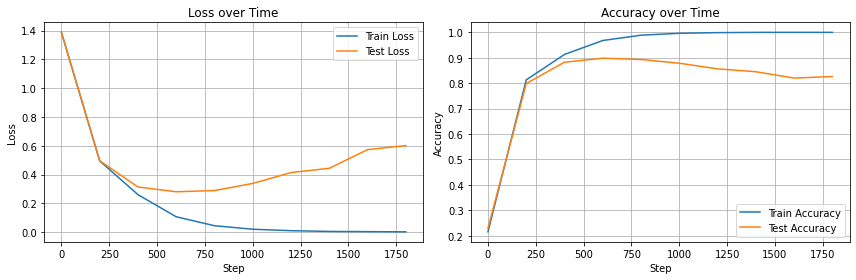

Classification Report:

              precision    recall  f1-score   support

          AC       0.76      0.90      0.82       797
          LF       0.56      0.68      0.61       482

   micro avg       0.68      0.82      0.74      1279
   macro avg       0.66      0.79      0.72      1279
weighted avg       0.68      0.82      0.74      1279

F1 Score: 0.7429989365473237
Accuracy: 0.839584996009577


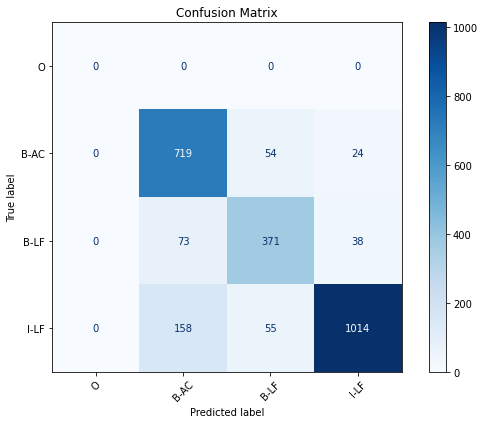

In [13]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.3593, accuracy 0.3306 | Test loss 1.3600, accuracy 0.3178
Step 200: Train loss 0.7402, accuracy 0.7262 | Test loss 0.7188, accuracy 0.7275
Step 400: Train loss 0.5827, accuracy 0.7705 | Test loss 0.5623, accuracy 0.7826
Step 600: Train loss 0.4209, accuracy 0.8437 | Test loss 0.4804, accuracy 0.8272
Step 800: Train loss 0.3131, accuracy 0.8962 | Test loss 0.4912, accuracy 0.8156
Step 1000: Train loss 0.2342, accuracy 0.9230 | Test loss 0.6669, accuracy 0.7306
Step 1200: Train loss 0.1845, accuracy 0.9453 | Test loss 0.6829, accuracy 0.7377
Step 1400: Train loss 0.1191, accuracy 0.9703 | Test loss 0.7085, accuracy 0.7417
Step 1600: Train loss 0.0843, accuracy 0.9788 | Test loss 1.3252, accuracy 0.6216
Step 1800: Train loss 0.0695, accuracy 0.9819 | Test loss 1.2621, accuracy 0.6614


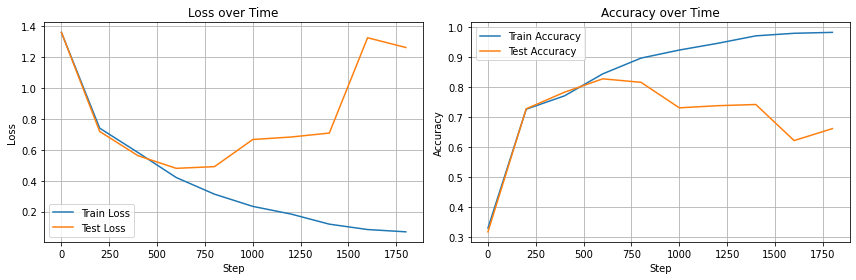

Classification Report:

              precision    recall  f1-score   support

          AC       0.48      0.99      0.65       797
          LF       0.62      0.40      0.48       482

   micro avg       0.50      0.77      0.61      1279
   macro avg       0.55      0.69      0.57      1279
weighted avg       0.53      0.77      0.59      1279

F1 Score: 0.6071317829457364
Accuracy: 0.6400638467677574


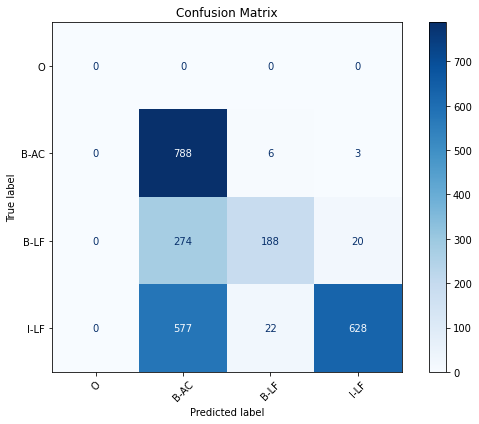

In [14]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.3841, accuracy 0.1844 | Test loss 1.3852, accuracy 0.1818
Step 200: Train loss 1.2799, accuracy 0.4769 | Test loss 1.2764, accuracy 0.4931
Step 400: Train loss 1.2255, accuracy 0.4490 | Test loss 1.2030, accuracy 0.5027
Step 600: Train loss 1.1732, accuracy 0.4786 | Test loss 1.1686, accuracy 0.4804
Step 800: Train loss 1.1460, accuracy 0.4648 | Test loss 1.1465, accuracy 0.4674
Step 1000: Train loss 1.1198, accuracy 0.4702 | Test loss 1.1151, accuracy 0.4829
Step 1200: Train loss 1.0995, accuracy 0.4766 | Test loss 1.0980, accuracy 0.4891
Step 1400: Train loss 1.0848, accuracy 0.4752 | Test loss 1.0790, accuracy 0.4942
Step 1600: Train loss 1.0908, accuracy 0.4455 | Test loss 1.0782, accuracy 0.4755
Step 1800: Train loss 1.0792, accuracy 0.4531 | Test loss 1.0582, accuracy 0.4888


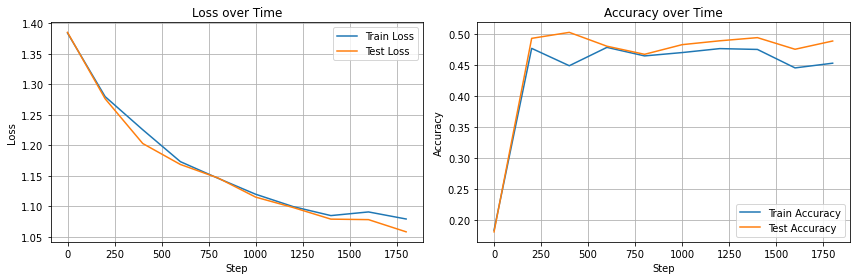

Classification Report:

              precision    recall  f1-score   support

          AC       0.00      0.00      0.00       797
          LF       0.00      0.00      0.00       482

   micro avg       0.00      0.00      0.00      1279
   macro avg       0.00      0.00      0.00      1279
weighted avg       0.00      0.00      0.00      1279

F1 Score: 0.0013080444735120993
Accuracy: 0.4896249002394254


/user/HS400/rh01555/.local/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


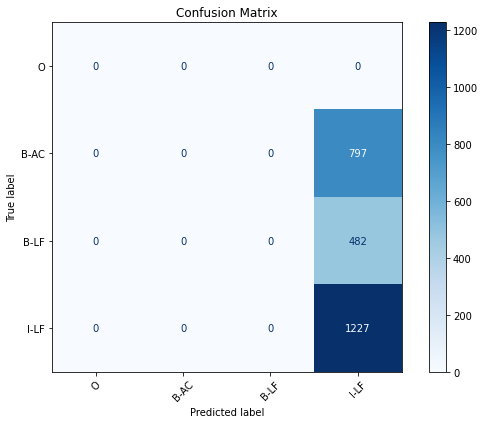

In [15]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.0003)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.4026, accuracy 0.2245 | Test loss 1.4118, accuracy 0.1694
Step 200: Train loss 0.6759, accuracy 0.7558 | Test loss 0.6490, accuracy 0.7555
Step 400: Train loss 0.5786, accuracy 0.7755 | Test loss 0.5388, accuracy 0.7993
Step 600: Train loss 0.5055, accuracy 0.8147 | Test loss 0.5189, accuracy 0.7936
Step 800: Train loss 0.4804, accuracy 0.8195 | Test loss 0.4699, accuracy 0.8139
Step 1000: Train loss 0.3982, accuracy 0.8531 | Test loss 0.4344, accuracy 0.8407
Step 1200: Train loss 0.3391, accuracy 0.8794 | Test loss 0.3959, accuracy 0.8501
Step 1400: Train loss 0.3146, accuracy 0.8843 | Test loss 0.3855, accuracy 0.8617
Step 1600: Train loss 0.2979, accuracy 0.8927 | Test loss 0.3474, accuracy 0.8709
Step 1800: Train loss 0.2841, accuracy 0.9006 | Test loss 0.2945, accuracy 0.8904


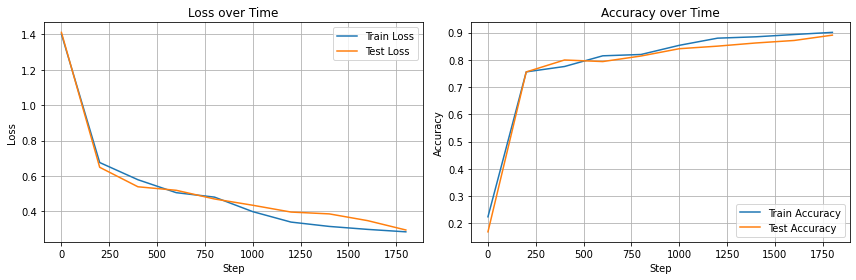

Classification Report:

              precision    recall  f1-score   support

          AC       0.93      0.87      0.90       797
          LF       0.65      0.84      0.73       482

   micro avg       0.80      0.86      0.83      1279
   macro avg       0.79      0.86      0.82      1279
weighted avg       0.82      0.86      0.84      1279

F1 Score: 0.8303740083112957
Accuracy: 0.8802873104549083


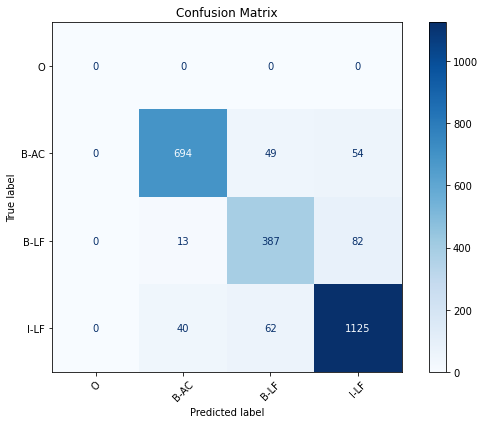

In [16]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=0.001)
model = train_model(model, optimizer)
evaluate_model(model)